### Follow up analysis (revisions)

#### Print out the FC & actflow contributions of each rule layer vertex onto the hidden layer

2/11/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from pandas.plotting import table 
import nibabel as nib
import os
import tools
sns.set_style("whitegrid")

In [2]:
projectdir = '/home/ti61/f_mc1689_1/SRActFlow/'

#### Load in CAB-NP ROI labels
cabn_labels = pd.read_csv(projectdir + 'data/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt',header=0,delimiter='\t')
df_labels = cabn_labels.iloc[0:360]
df_labels.reset_index()
del df_labels['INDEX'], df_labels["KEYVALUE"]

# Using final partition
networkdef = df_labels['NETWORKKEY'].values
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

glasserfile2 = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

#### Data directories

In [3]:
hiddenfile = projectdir + 'data/results/MAIN/RSA/RSA_Similarity_SortedRegions2.txt'
rulefile = projectdir + 'data/results/MAIN/RuleDecoding/12Rule_Regions.csv'
orifile = projectdir + 'data/results/MAIN/InputStimuliDecoding/InputStimuliRegions_ORI.csv'
colorfile = projectdir + 'data/results/MAIN/InputStimuliDecoding/InputStimuliRegions_COLOR.csv'
pitchfile = projectdir + 'data/results/MAIN/InputStimuliDecoding/InputStimuliRegions_PITCH.csv'
constantfile = projectdir + 'data/results/MAIN/InputStimuliDecoding/InputStimuliRegions_CONSTANT.csv'


hiddenregions = np.loadtxt(hiddenfile)[:10]
ruleregions = np.loadtxt(rulefile)
oriregions = np.loadtxt(orifile)
colorregions = np.loadtxt(colorfile)
pitchregions = np.loadtxt(pitchfile)
constantregions = np.loadtxt(constantfile)

#### Load FC

In [4]:
import SRModels
ruletype = '12'

Model = SRModels.Model(projectdir=projectdir,ruletype=ruletype,n_hiddenregions=10,randomize=False)
Model.loadModelFC()

Constructing model with 10 hidden regions
Load Model FC weights


#### Identify rule layer vertices

In [5]:
rule_regions_ind = []
for roi in ruleregions:
    if roi in hiddenregions:
        continue
    ind = np.where(glasser2==roi+1)[0]
    rule_regions_ind.extend(ind)
rule_regions_ind = np.asarray(rule_regions_ind)

# Estimate intrinsic FC contributions from rule layer to hidden layer

In [127]:
source2hidden_vertex = np.matmul(Model.eig_12rule2hidden.T, Model.fc_12rule2hidden)
source_strength = np.mean(source2hidden_vertex,axis=1)

#### Visualize on surface

In [126]:
#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
source_strength_64k = np.zeros((glasser2.shape[0],1))

roicount = 0
for roi in range(nParcels):
    vertex_ind = np.where(glasser2==roi+1)[0]
    source_strength_64k[rule_regions_ind,0] = source_strength
        

    roicount += 1
    
#### 
# Write file to csv and run wb_command
# outdir = projectdir + 'docs/scripts/'
# filename = 'rulelayer_fcstrength'
# np.savetxt(outdir + filename + '.csv', source_strength_64k, fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)


#### Construct radar plot

In [140]:
#### First create dataframe to capture contribution of each network (on average)
fcstrength_region = np.zeros((360))
for roi in ruleregions:
    if roi in hiddenregions:
        continue
    ind = np.where(glasser2==roi+1)[0]
#     fcstrength_region[int(roi)] = np.sum(np.abs(source_strength_64k[ind]))
    fcstrength_region[int(roi)] = np.sum(source_strength_64k[ind])

fcstrength_network = np.zeros((len(orderednetworks),))    
i = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    fcstrength_network[i] = np.sum(fcstrength_region[net_ind])
    i += 1
    
df = {}
df['FC'] = []
df['Network'] = []
df['Region'] = []
sorted_index = sorted(range(len(fcstrength_network)), key=lambda k: -fcstrength_network[k])
for i in range(len(orderednetworks)):
    net = orderednetworks[i]
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        if roi in ruleregions:
            if roi in hiddenregions: 
                continue
            df['FC'].append(fcstrength_region[int(roi)])
            df['Network'].append(OrderedNetworks[i])
            df['Region'].append(roi)
            
df = pd.DataFrame(df)

# plt.figure(figsize=(10,7))
# ax = sns.boxplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#            meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#            medianprops={'linestyle':'-'},sym='',whis=0);
# sns.swarmplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#             alpha=0.5,dodge=True);
# plt.title('FC contribution to hidden layer',fontsize=30);
# plt.ylabel("Summed FC weights",fontsize=22);
# plt.xlabel('Network',fontsize=22);
# plt.xticks(fontsize=16,rotation=-45);
# plt.yticks(fontsize=16);
# # handles, labels = ax.get_legend_handles_labels()
# # l = plt.legend(handles[-12:], labels[-12:], borderaxespad=0., bbox_to_anchor=(1.05, 1), prop={'size': 12})
# # plt.legend()
# plt.tight_layout()
# # plt.savefig('HiddenlayerRSA_FuncNetSimilarity.png',dpi=300)

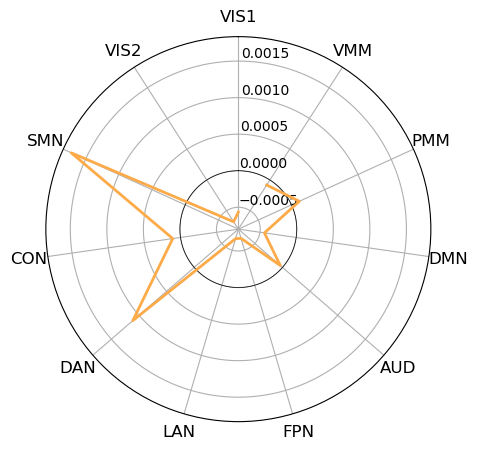

In [141]:
import statsmodels.stats.api as sm
radianpalette = sns.xkcd_palette(['grey','light orange','lavender'])

plt.style.use('default')
# function
error_alpha=0.25

#set up the polar plot
n_nets = len(df['Network'].unique())

#convert index to radians
radians = np.linspace(0, 2 * np.pi, num=n_nets, endpoint=False)

plt.figure(figsize=(5,5))
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')

# plot a solid line around 0
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',lw=0.5)

# Set up labels
ax.set_xticks(radians)
ax.set_xticklabels(OrderedNetworks, size=12)
# ax.set_yticks(np.arange(-0.01,.005,.005))
# ax.set_yticklabels(np.arange(-0.01,.1,.005), size=8)
# move the 'y-axis' to a gap
ax.set_rlabel_position(-1)

y = []
y_ci_lo = []
y_ci_hi = []

# get the data from df
for net in df['Network'].unique():
    data = df[df.Network==net].FC.values
    y.append(np.sum(data))
    lo,hi = sm.DescrStatsW(data).tconfint_mean()
    y_ci_lo.append(lo)
    y_ci_hi.append(hi)

# plot the mean
ax.plot(radians, y,lw=2,color=radianpalette[1])
#ax.tick_params(labelsize=8)

#fill in confidence intervals
# ax.fill_between(radians, y_ci_lo, y_ci_hi, alpha=error_alpha,color=radianpalette[1])
# plt.savefig(figure_dir+'network-flow-roi-'+str(roi)+'.svg',dpi=600)
plt.show()

___

# Run ActFlow contributions across all rules

#### Load in data

In [6]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']


n_features = 12 # 12 rules, 16 stim combos
data_task = np.zeros((len(glasser2),n_features,len(subjNums)))
rules = ['Logic','Sensory','Motor']


scount = 0
for subj in subjNums:
    print('Loading subject', subj)
    indstart = 0
    indend = 4
    for rule in rules:
        data_task[:,indstart:indend,scount] = tools.loadRuleEncoding(subj,rule)
        indstart += 4
        indend += 4

Loading subject 013


/projects/f_mc1689_1/AnalysisTools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Loading subject 014
Loading subject 016
Loading subject 017
Loading subject 018
Loading subject 021
Loading subject 023
Loading subject 024
Loading subject 026
Loading subject 027
Loading subject 028
Loading subject 030
Loading subject 031
Loading subject 032
Loading subject 033
Loading subject 034
Loading subject 035
Loading subject 037
Loading subject 038
Loading subject 039
Loading subject 040
Loading subject 041
Loading subject 042
Loading subject 043
Loading subject 045
Loading subject 046
Loading subject 047
Loading subject 048
Loading subject 049
Loading subject 050
Loading subject 053
Loading subject 055
Loading subject 056
Loading subject 057
Loading subject 058
Loading subject 062
Loading subject 063
Loading subject 066
Loading subject 067
Loading subject 068
Loading subject 069
Loading subject 070
Loading subject 072
Loading subject 074
Loading subject 075
Loading subject 076
Loading subject 077
Loading subject 081
Loading subject 085
Loading subject 086
Loading subject 087


# Plot mean task rule activity (inputs)

### Visualize on surface

In [7]:
rule_activity = np.mean(np.mean(data_task[rule_regions_ind,:,:],axis=2),axis=1)

#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
activityinput_64k = np.zeros((glasser2.shape[0],1))

roicount = 0
for roi in range(nParcels):
    vertex_ind = np.where(glasser2==roi+1)[0]
    activityinput_64k[rule_regions_ind,0] = rule_activity
        

    roicount += 1
    
#### 
# Write file to csv and run wb_command
outdir = projectdir + 'docs/scripts/'
filename = 'rulelayer_inputs'
np.savetxt(outdir + filename + '.csv', activityinput_64k, fmt='%s')
wb_file = filename + '.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)


0

#### Construct radar plot

In [9]:
#### First create dataframe to capture contribution of each network (on average)
ruleactivity_region = np.zeros((360))
for roi in ruleregions:
    if roi in hiddenregions:
        continue
    ind = np.where(glasser2==roi+1)[0]
#     actflowcontribution_region[int(roi)] = np.sum(np.abs(actflow_contributions_64k[ind]))
    ruleactivity_region[int(roi)] = np.sum(activityinput_64k[ind])


ruleactivity_network = np.zeros((len(orderednetworks),))    
i = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    ruleactivity_network[i] = np.sum(ruleactivity_region[net_ind])
    i += 1
    
df = {}
df['Activation'] = []
df['Network'] = []
df['Region'] = []
sorted_index = sorted(range(len(ruleactivity_network)), key=lambda k: -ruleactivity_network[k])
for i in range(len(orderednetworks)):
    net = orderednetworks[i]
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        if roi in ruleregions:
            if roi in hiddenregions: 
                continue
            df['Activation'].append(ruleactivity_region[int(roi)])
            df['Network'].append(OrderedNetworks[i])
            df['Region'].append(roi)
            
df = pd.DataFrame(df)

# plt.figure(figsize=(10,7))
# ax = sns.boxplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#            meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#            medianprops={'linestyle':'-'},sym='',whis=0);
# sns.swarmplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#             alpha=0.5,dodge=True);
# plt.title('FC contribution to hidden layer',fontsize=30);
# plt.ylabel("Summed FC weights",fontsize=22);
# plt.xlabel('Network',fontsize=22);
# plt.xticks(fontsize=16,rotation=-45);
# plt.yticks(fontsize=16);
# # handles, labels = ax.get_legend_handles_labels()
# # l = plt.legend(handles[-12:], labels[-12:], borderaxespad=0., bbox_to_anchor=(1.05, 1), prop={'size': 12})
# # plt.legend()
# plt.tight_layout()
# # plt.savefig('HiddenlayerRSA_FuncNetSimilarity.png',dpi=300)

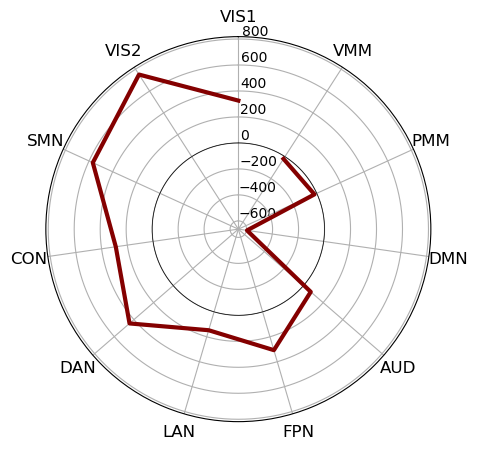

In [13]:
import statsmodels.stats.api as sm
radianpalette = sns.xkcd_palette(['grey','dark cyan','dark red'])

plt.style.use('default')
# function
error_alpha=0.25

#set up the polar plot
n_nets = len(df['Network'].unique())

#convert index to radians
radians = np.linspace(0, 2 * np.pi, num=n_nets, endpoint=False)

plt.figure(figsize=(5,5))
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')

# plot a solid line around 0
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',lw=0.5)

# Set up labels
ax.set_xticks(radians)
ax.set_xticklabels(OrderedNetworks, size=12)
# ax.set_yticks(np.arange(-0.01,.1,.005))
# ax.set_yticklabels(np.arange(-0.01,.1,.005), size=8)
# move the 'y-axis' to a gap
ax.set_rlabel_position(-1)

y = []
y_ci_lo = []
y_ci_hi = []

# get the data from df
for net in df['Network'].unique():
    data = df[df.Network==net].Activation.values
    y.append(np.sum(data))
    lo,hi = sm.DescrStatsW(data).tconfint_mean()
    y_ci_lo.append(lo)
    y_ci_hi.append(hi)

# plot the mean
ax.plot(radians, y,lw=3,color=radianpalette[2])
#ax.tick_params(labelsize=8)

#fill in confidence intervals
# ax.fill_between(radians, y_ci_lo, y_ci_hi, alpha=error_alpha,color=radianpalette[1])
plt.savefig('RuleActivity_Inputs.png',dpi=300)
plt.show()

# Plot mean actflow contributions to conjunction hubs

In [188]:
rule_activity = np.mean(np.mean(data_task[rule_regions_ind,:,:],axis=2),axis=1)
source2hidden_vertex = np.matmul(Model.eig_12rule2hidden.T, Model.fc_12rule2hidden)    
source_strength = np.mean(source2hidden_vertex,axis=1)

actflow_contributions = np.multiply(source_strength,rule_activity)


### Visualize on surface

In [189]:
#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
actflow_contributions_64k = np.zeros((glasser2.shape[0],1))

roicount = 0
for roi in range(nParcels):
    vertex_ind = np.where(glasser2==roi+1)[0]
    actflow_contributions_64k[rule_regions_ind,0] = actflow_contributions
        

    roicount += 1
    
#### 
# # Write file to csv and run wb_command
# outdir = projectdir + 'docs/scripts/'
# filename = 'rulelayer_actflowcontribution'
# np.savetxt(outdir + filename + '.csv', actflow_contributions_64k, fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)


#### Construct radar plot

In [190]:
#### First create dataframe to capture contribution of each network (on average)
actflowcontribution_region = np.zeros((360))
for roi in ruleregions:
    if roi in hiddenregions:
        continue
    ind = np.where(glasser2==roi+1)[0]
#     actflowcontribution_region[int(roi)] = np.sum(np.abs(actflow_contributions_64k[ind]))
    actflowcontribution_region[int(roi)] = np.sum(actflow_contributions_64k[ind])


actflowcontribution_network = np.zeros((len(orderednetworks),))    
i = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    actflowcontribution_network[i] = np.sum(actflowcontribution_region[net_ind])
    i += 1
    
df = {}
df['ActFlow'] = []
df['Network'] = []
df['Region'] = []
sorted_index = sorted(range(len(actflowcontribution_network)), key=lambda k: -actflowcontribution_network[k])
for i in range(len(orderednetworks)):
    net = orderednetworks[i]
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        if roi in ruleregions:
            if roi in hiddenregions: 
                continue
            df['ActFlow'].append(actflowcontribution_region[int(roi)])
            df['Network'].append(OrderedNetworks[i])
            df['Region'].append(roi)
            
df = pd.DataFrame(df)

# plt.figure(figsize=(10,7))
# ax = sns.boxplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#            meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#            medianprops={'linestyle':'-'},sym='',whis=0);
# sns.swarmplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#             alpha=0.5,dodge=True);
# plt.title('FC contribution to hidden layer',fontsize=30);
# plt.ylabel("Summed FC weights",fontsize=22);
# plt.xlabel('Network',fontsize=22);
# plt.xticks(fontsize=16,rotation=-45);
# plt.yticks(fontsize=16);
# # handles, labels = ax.get_legend_handles_labels()
# # l = plt.legend(handles[-12:], labels[-12:], borderaxespad=0., bbox_to_anchor=(1.05, 1), prop={'size': 12})
# # plt.legend()
# plt.tight_layout()
# # plt.savefig('HiddenlayerRSA_FuncNetSimilarity.png',dpi=300)

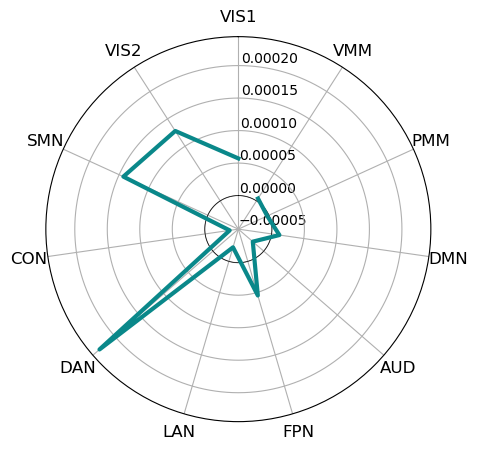

In [191]:
import statsmodels.stats.api as sm
radianpalette = sns.xkcd_palette(['grey','dark cyan','dark red'])

plt.style.use('default')
# function
error_alpha=0.25

#set up the polar plot
n_nets = len(df['Network'].unique())

#convert index to radians
radians = np.linspace(0, 2 * np.pi, num=n_nets, endpoint=False)

plt.figure(figsize=(5,5))
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')

# plot a solid line around 0
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',lw=0.5)

# Set up labels
ax.set_xticks(radians)
ax.set_xticklabels(OrderedNetworks, size=12)
# ax.set_yticks(np.arange(-0.01,.1,.005))
# ax.set_yticklabels(np.arange(-0.01,.1,.005), size=8)
# move the 'y-axis' to a gap
ax.set_rlabel_position(-1)

y = []
y_ci_lo = []
y_ci_hi = []

# get the data from df
for net in df['Network'].unique():
    data = df[df.Network==net].ActFlow.values
    y.append(np.sum(data))
    lo,hi = sm.DescrStatsW(data).tconfint_mean()
    y_ci_lo.append(lo)
    y_ci_hi.append(hi)

# plot the mean
ax.plot(radians, y,lw=3,color=radianpalette[1])
#ax.tick_params(labelsize=8)

#fill in confidence intervals
# ax.fill_between(radians, y_ci_lo, y_ci_hi, alpha=error_alpha,color=radianpalette[1])
# plt.savefig('ActFlowContributions_Mean.png',dpi=300)
plt.show()

## Actflow variability (across task rules) across networks

In [193]:
rule_activity = np.mean(data_task[rule_regions_ind,:,:],axis=2)
source2hidden_vertex = np.matmul(Model.eig_12rule2hidden.T, Model.fc_12rule2hidden)   
source_strength = np.mean(source2hidden_vertex,axis=1)

taskrule_64taskset = np.zeros((rule_activity.shape[0],64))
i = 0
for logic in range(0,4):
    for sensory in range(4,8):
        for motor in range(8,12):
            taskrule_64taskset[:,i] = rule_activity[:,logic] + rule_activity[:,sensory] + rule_activity[:,motor]
            i += 1

taskrules = rule_activity
actflow_variability_crossrule = np.zeros((taskrules.shape[1],len(source_strength)))
for cond in range(taskrules.shape[1]):
    actflow_variability_crossrule[cond,:] = np.multiply(source_strength,taskrules[:,cond])



actflow_variability = np.std(actflow_variability_crossrule,axis=0)


### Visualize on surface

In [197]:
#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
actflow_variability_64k = np.zeros((glasser2.shape[0],1))

roicount = 0
for roi in range(nParcels):
    vertex_ind = np.where(glasser2==roi+1)[0]
    actflow_variability_64k[rule_regions_ind,0] = actflow_variability
        

    roicount += 1
    
#### 
## Write file to csv and run wb_command
# outdir = projectdir + 'docs/scripts/'
# filename = 'rulelayer_actflowvariability'
# np.savetxt(outdir + filename + '.csv', actflow_variability_64k, fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
# os.system(wb_command)


0

#### Construct radar plot

In [195]:
#### First create dataframe to capture contribution of each network (on average)
actflow_variability_region = np.zeros((360))
for roi in ruleregions:
    if roi in hiddenregions:
        continue
    ind = np.where(glasser2==roi+1)[0]
#     actflowcontribution_region[int(roi)] = np.sum(np.abs(actflow_contributions_64k[ind]))
    actflow_variability_region[int(roi)] = np.sum(actflow_variability_64k[ind])


actflow_variability_network = np.zeros((len(orderednetworks),))    
i = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    actflow_variability_network[i] = np.sum(actflow_variability_region[net_ind])
    i += 1
    
df = {}
df['ActFlow'] = []
df['Network'] = []
df['Region'] = []
sorted_index = sorted(range(len(actflow_variability_network)), key=lambda k: -actflow_variability_network[k])
for i in range(len(orderednetworks)):
    net = orderednetworks[i]
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        if roi in ruleregions:
            if roi in hiddenregions: 
                continue
            df['ActFlow'].append(actflow_variability_region[int(roi)])
            df['Network'].append(OrderedNetworks[i])
            df['Region'].append(roi)
            
df = pd.DataFrame(df)

# plt.figure(figsize=(10,7))
# ax = sns.boxplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#            meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
#            medianprops={'linestyle':'-'},sym='',whis=0);
# sns.swarmplot(x="Network",y="FC",data=df,
#             palette=networkpalette,
#             alpha=0.5,dodge=True);
# plt.title('FC contribution to hidden layer',fontsize=30);
# plt.ylabel("Summed FC weights",fontsize=22);
# plt.xlabel('Network',fontsize=22);
# plt.xticks(fontsize=16,rotation=-45);
# plt.yticks(fontsize=16);
# # handles, labels = ax.get_legend_handles_labels()
# # l = plt.legend(handles[-12:], labels[-12:], borderaxespad=0., bbox_to_anchor=(1.05, 1), prop={'size': 12})
# # plt.legend()
# plt.tight_layout()
# # plt.savefig('HiddenlayerRSA_FuncNetSimilarity.png',dpi=300)

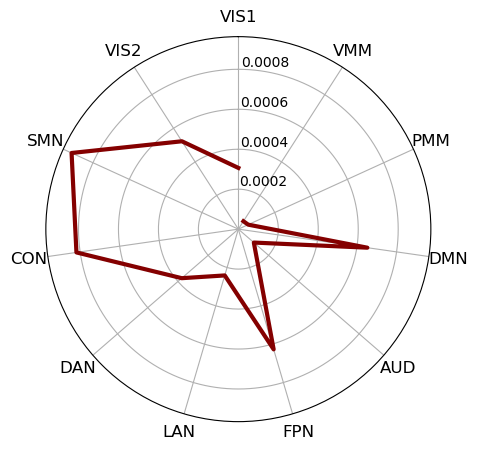

In [196]:
import statsmodels.stats.api as sm
radianpalette = sns.xkcd_palette(['grey','blue','dark red'])

plt.style.use('default')
# function
error_alpha=0.25

#set up the polar plot
n_nets = len(df['Network'].unique())

#convert index to radians
radians = np.linspace(0, 2 * np.pi, num=n_nets, endpoint=False)

plt.figure(figsize=(5,5))
ax = plt.axes(polar=True)
ax.set_theta_zero_location('N')

# plot a solid line around 0
r = np.arange(0,2*np.pi,0.01)
y = np.zeros((len(r)))
ax.plot(r, y,'k',lw=0.5)

# Set up labels
ax.set_xticks(radians)
ax.set_xticklabels(OrderedNetworks, size=12)
# ax.set_yticks(np.arange(-0.01,.1,.005))
# ax.set_yticklabels(np.arange(-0.01,.1,.005), size=8)
# move the 'y-axis' to a gap
ax.set_rlabel_position(-1)

y = []
y_ci_lo = []
y_ci_hi = []

# get the data from df
for net in df['Network'].unique():
    data = df[df.Network==net].ActFlow.values
    y.append(np.sum(data))
    lo,hi = sm.DescrStatsW(data).tconfint_mean()
    y_ci_lo.append(lo)
    y_ci_hi.append(hi)

# plot the mean
ax.plot(radians, y,lw=3,color=radianpalette[2])
#ax.tick_params(labelsize=8)

#fill in confidence intervals
# ax.fill_between(radians, y_ci_lo, y_ci_hi, alpha=error_alpha,color=radianpalette[1])
# plt.savefig('ActFlowContributions_Variance.png',dpi=300)
plt.show()